<a href="https://colab.research.google.com/github/ZackAkil/machine-learning-trenches-and-highways/blob/master/answers/Machine_Learning_Trenches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Trenches

Thie notebook will walk you trough the raw process of building a ML model for predicting **if a patients X-ray contains pneumonia or not**.

![alt text](https://raw.githubusercontent.com/ZackAkil/machine-learning-trenches-and-highways/master/misc/xray.png)

First we will import our data

---
**Practicle note ⚡**: becuase we are importing data direct from Cloud Storage into Colab, the data never touches our local computer and is leveraging the super fast  download speeds between Google services.

Download the data using the following command:

```bash
!gsutil cp "gs://raw-data-sets/x-ray-pneumonia/training x-ray data.zip" .
```

In [1]:
# [TASK] download data using gsutil 

!gsutil cp "gs://raw-data-sets/x-ray-pneumonia/training x-ray data.zip" .

Copying gs://raw-data-sets/x-ray-pneumonia/training x-ray data.zip...
/ [1 files][  1.2 GiB/  1.2 GiB]   68.3 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


Now that the zip file of our data is downloaded, we can unzip it using:
```bash

!unzip -q "training x-ray data.zip"
```

In [0]:
# [TASK] unzip the data

!unzip -q "training x-ray data.zip"

## Go OOM or go home🎈
(OOM means "Out of memory")

Machine learning models love having lots of data to learn from, unfortunatly (and especially for image based models) all that data can quickly fill up the memory of our computers causing OOM (Out of Memory) errors if we are lucky, and more obscure errors when we are not so lucky. 

There are a couple of ways to work through this problem:

-

**A.**  Brute force it 

---
You can run the code on a local machine that has more memory, **or** set up and configure your own remote VM with more memory, **or** use a cloud hosted managed notebook service like [AI Platform Noetbooks](https://cloud.google.com/ai-platform-notebooks/) that allows you to easily customise the harware of a remote notebook environment.

-

**B.** Just use less data

---
Usually the quickest solution is to just use a sample of your data that fits in memory, however this isn't ideal if you want the best possible model, it is good if you're just experimenting around with POCs (proof of concepts).

-

**C.** Compress your data (mostly for images)

---
You don't normally need high resolution images of cats to detect if there is a cat, so it's common to see machine learning models trained on what we would see as "low resolution" images e.g 128x128 pixels or even in the case of the famous [MNIST dataset ](https://en.wikipedia.org/wiki/MNIST_database): 28x28 pixels.


Example 4mb image of cat

<img src="https://storage.googleapis.com/random-assets/images/cat_bed_4mb.jpg" height=200></img>

Example 70kb image of cat

<img src="https://storage.googleapis.com/random-assets/images/cat_bed_80kb.png" height=200></img>

In both images you can clearly see that there is a cat, therefore a machine learning model could learn that there is a cat from both, except for the same memory used in the first (4mb) image you could load in more than 50 (70kb) images  and expect to get the same performance from your model.

### Now lets look at some of our data:

In [1]:
# import package that lets us navigate files
import os

# get list of file names in the NORMAL folder (not pneumonia)
folder_name = "NORMAL/"
file_name_list = os.listdir(folder_name)

# print out the file name of the first NORMAL image
print(folder_name + file_name_list[0])

NORMAL/IM-0207-0001.jpeg


In [0]:
# import package that lets us load in an image using a file name
import skimage.io as io

# load image
image = io.imread(folder_name + file_name_list[0])

Let's just print out the image using the `print()` function, what do you expect to see?
```python
print(your image varible)
```

In [3]:
# [TASK] print out the image you just loaded in

print(image)

[[  0 152 154 ... 128 131 133]
 [  2 148 155 ... 126 131 134]
 [  0 141 146 ... 125 132 133]
 ...
 [  0   0   0 ...   6   4   4]
 [  0   0   0 ...   9   2   2]
 [  0   0   0 ...  11   4   3]]


Numbers??? We'll display the image properly soon enough.

You can see the dimensions (resolution) of the image by looking at the `.shape` property of the image like so:

```python
print(my_image.shape)
```

In [4]:
# [TASK] check the dimensions of your image

print(image.shape)

(1049, 1426)


Let's actually see the image, there is a very popular data visualisation package called [`matplotlib`](https://matplotlib.org/) that we can use for that. Use the following code to display the image:
```python
plt.imshow(my_image)
```



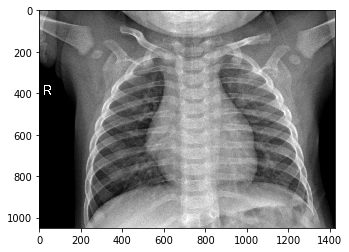

In [5]:
# import package that lets us plot charts and graphics
import matplotlib.pyplot as plt

# [TASK] display the image

plt.imshow(image, cmap="gray")

Does the colour of the image look abit strange to you? You can set the **[cmap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)** (colour map) of the image to grayscale if you want the more "x-ray" look by changing the code to :

```python
plt.imshow(image, cmap="gray")

```

## Let's import a lot of data now
When dealing with real data it's unlikly to ever be in exactly the right format. This lesson is no different! 

Our data is stored across multiple folders in diferent types of images (**grayscale** and **<font color='red'>R</font><font color='green'>G</font><font color='blue'>B</font>**) and even different resolutions. A Machine Leanring model **can not** handle different types of images without preprocessing.

To save everyone alot of headache below is a function that will do the preprocessing on this data for us. Specifically it will

1.   Import each image as a matrix
2.   Convert RGB images to grayscale
3.   Resize all images to be the same resolution

[**TASK**] Read through and run the code to create the function `load_images_from_folder`

In [0]:
# import package that lets you resize images
import cv2

# import package that will let us combine all the images into one big matrix
import numpy as np

# create function for preprocessing the images
def load_images_from_folder(path, max_to_import=1000, image_resize_shape=(200, 200)):
  
  print('Started import from {}...'.format(path))
  
  image_list = []    
  image_count = 0
  
  for img_file_name in os.listdir(path):
    
      # get all file names that end in 'jpeg', e.i are images       
      if img_file_name[-4:] != 'jpeg':
        continue
      
      # import image into matrix format
      image = io.imread(os.path.join(path, img_file_name))

      image_count +=1
      
      # annoyingly some of the images are RGB and and have a shape like [480, 640, 3]    
      # whilst most others are grayscale and have a shape like [480, 640]. So let's convert
      # the multi-channel RGB images to single channel images.       
      if len(image.shape) > 2:
        image = image[:,:,0]

      # resize image and add it to the list of images
      image_list.append(cv2.resize(image, dsize=image_resize_shape)) 

      # every 200 images print out a message so that we know it's doing something      
      if (image_count%200)==0:
        print('imported ', image_count)

      # quit function when reached max_to_import          
      if image_count >= max_to_import:
        break
  
  print('...done, showing example image') 
  
  plt.imshow(image_list[0], CMAP='gray')
  plt.show()
  
  return np.stack(image_list)

Let's use the created function 

**BUT** you need to make a choice of how much data to import  and what size to set all of the images to:

**FYI**: there is 1500 NORMAL images and  4000 PNEUMONIA images, and you could use image shapes of (1, 1) all the way to (2000, 2000). 

**You're likely going to be experimenting with these values later on.**

Started import from NORMAL/...
...done, showing example image


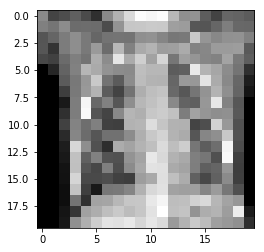

In [7]:
# use this code to test out what resolution you want to import the images at:

# play with the following numbers:
TEST_RESIZE_SHAPE = (20, 20)

# don't have to change this code
test_image = load_images_from_folder('NORMAL/', 
                                     max_to_import=1, 
                                     image_resize_shape=TEST_RESIZE_SHAPE)

*Scroll to the very bottom to see some examples of numbers to use for the next section*.

Started import from NORMAL/...
...done, showing example image


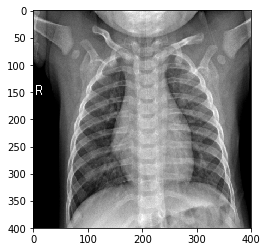

Started import from PNEUMONIA/...
...done, showing example image


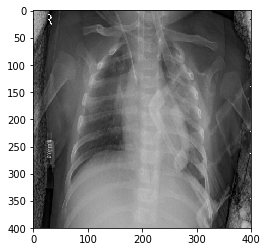

In [111]:
# [TASK] Pick a number of images to import for each category
# and the IMAGE_RESIZE_SHAPE (replace the 10's)

NUMBER_OF_NORMAL_IMAGES_TO_IMPORT = 10 # up to 1500 
NUMBER_OF_PNEUMONIA_IMAGES_TO_IMPORT = 10 # up to 4000
IMAGE_RESIZE_SHAPE = (400, 400)


# don't need to change the following code
normal = load_images_from_folder('NORMAL/', 
                                 max_to_import=NUMBER_OF_NORMAL_IMAGES_TO_IMPORT, 
                                 image_resize_shape = IMAGE_RESIZE_SHAPE)
pneumonia = load_images_from_folder('PNEUMONIA/', 
                                    max_to_import = NUMBER_OF_PNEUMONIA_IMAGES_TO_IMPORT, 
                                    image_resize_shape = IMAGE_RESIZE_SHAPE)



## Building the training dataset 🏫

We now need to organise our data so that we have the "**input**" data to our model (the image of an X-ray) along side the correct answers (the "**output**" data). In our case we want our model to output "**0**" went it's a "**normal**" X-ray, and "**1**" when it's and X-ray of "**pneumonia**". 

It's machine learning convention to assign the input data to a varible **`X`** and the output data to a varible **`y`**.


## Some weird data structuring
We are going to convert our data from an image shape (e.g [400, 400] ) to a single array of values (e.g [160000]). This is so that we can feed it into our neural network later. 

We'll come back to this stage later 😉

In [0]:
# import package that will convert our outputs into the correct format
import keras

# join together the normal and pneumonia data 
X = np.concatenate([normal, pneumonia])
y = np.concatenate([np.zeros(len(normal)), np.ones(len(pneumonia))])


# change the shape of the image data to be a long line of pixels for the first neural network 
# X = X.reshape(len(X), IMAGE_RESIZE_SHAPE[0]*IMAGE_RESIZE_SHAPE[1] ) / 255.

# # [FUTURE TASK] replace the previous line with the following line
# for when you're using the next neural network type 
X = X.reshape(len(X), IMAGE_RESIZE_SHAPE[0], IMAGE_RESIZE_SHAPE[1], 1)/255.

# convert the labels into the correct format for the neural network
y = keras.utils.to_categorical(y, 2)

## Train/Test split our data
There is no point testing a student with the exact same questions you asked them in a class exersices, they could have just memorised the answers. Machine Learning models are no different. That is why it's important to split our data into a **training** set that it tries to learn from, and a **test** set that we use to check the models accuracy with.

  [Sci-Kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) is popular open-source machine learning library with a lot of tools for building models and data proprosessing, including a handy function that will train/test **and** shuffle our data for us. It's important to also shuffle our data as you want an even distribution of 'normal' and 'pneumonia' cases in both the training and test data. 

In [0]:
# import package that will do the train/test split and shuffle our data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

## Time to build a model 🤖
We are going to use a machine learning package called [Keras](https://keras.io/) that is a populare open-source package used for building neural networks.

In [0]:
# import packages for building a neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

## Building our network
The only thing that is defininate is the input shape layer (it has to match the input data we are using) and the output shape layer (it has to match the output data we are using), all of the inbetween layers are up for experimenting with. 

**you can add and remove the middle layers if you want to see how it changes the performance and training time**

In [0]:
# create our neural network layer by layer

# model = Sequential()
# model.add(Dense(1024, activation='relu', input_shape=(IMAGE_RESIZE_SHAPE[0]*IMAGE_RESIZE_SHAPE[1],)))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(2, activation='softmax'))


## [FUTURE TASK] replace all of the previous code with the following 
## code to create a neural network that is better for images

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(IMAGE_RESIZE_SHAPE[0], IMAGE_RESIZE_SHAPE[1], 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))


In [0]:
# compile model to set the optimisation algorithm and metrics we want to see during training

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [0]:
# train the model for 5 epochs with our training data, and test using our test data 

training_job = model.fit(X_train, y_train, 
          epochs=10,
          validation_data=(X_test, y_test))

## Train/Test score curves
Let's look at how our models performance changed whilst training. Using the following graphs we can see if our model is learning anything, and if so, if it is **overfitting** to our training data by looking at how close the train and test scores are:

In [0]:
# extract train (acc) and test (val_acc) scores from our training job
train_score = training_job.history['acc']
test_score = training_job.history['val_acc']

# plot scores
plt.plot(train_score, c='b', label='Train Score')
plt.plot(test_score, c='r', label='Test Score')
plt.ylim(0,1)
plt.legend()
plt.show()

Let's look at a confusion matrix describing the models performance on the test data:

You can play with the [confusion matrix playground](https://zackakil.github.io/precision-recall-playground/) to get a feel for what the numbers mean.

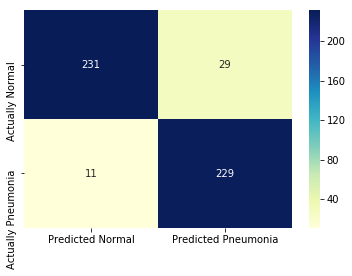

In [110]:
# import package that will generate the confusion matrix scores
from sklearn.metrics import confusion_matrix
# import packages that will help display the scores
import seaborn as sns
import pandas as pd

# generate confusion matrix scores
confusion_matrix_scores = confusion_matrix(y_test[:,1], 
                                           model.predict_classes(X_test))

# display scores as a heatmap
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Normal", "Predicted Pneumonia"],
                  index = ["Actually Normal", "Actually Pneumonia"])

sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

## If this is your first time with the first neural network structure:
It probebly doesn't look very good. Try changing:


*   The amount of data and the resize shape of the data 
*   The second network structure (make sure you change the data stucture to fit into the second network, back in the "**Some weird data structuring** part of the notebook)



## Let's go faster 🚀

Now that we are training a model, we might want it to train faster (your time is the most valuble resource). So let's swtch our run time to one with a GPU.   

In Colab the tool bar navigate to: **`Runtime > Change runtime type`**, then select **`GPU`** from the **`Hardware Accelerator`** dropdown.

You'll have to re-run all of your code now becuase the environment has to restart to attach the GPU.


## Now Re-run the notebook now that you have a GPU enabled environment!

# Lets use our model to make predictions ⚕️
We can call the `.predict` function on our model to send it predictions. Let's look what the raw prediction output looks like from the model: 

In [37]:
# make a prediction on the first 5 test images
predictions = model.predict(X_test[:5])
predictions

array([[2.4709820e-03, 9.9752909e-01],
       [2.3095007e-01, 7.6905000e-01],
       [3.5880742e-04, 9.9964118e-01],
       [1.0130374e-01, 8.9869624e-01],
       [1.2669596e-05, 9.9998736e-01]], dtype=float32)

Let's display the predictions along side the the true values and the input data (the X-ray image).

predicted: pneumonia
truth: pneumonia


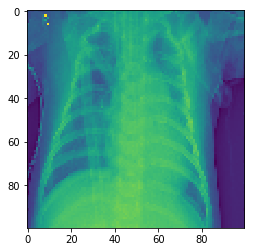

predicted: pneumonia
truth: normal


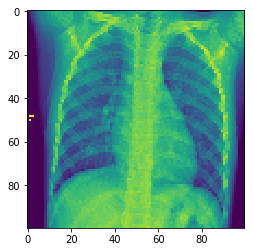

predicted: pneumonia
truth: pneumonia


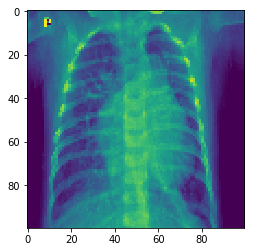

predicted: pneumonia
truth: normal


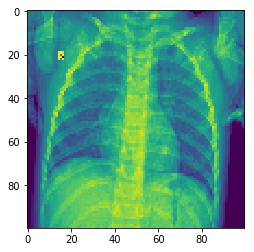

predicted: pneumonia
truth: pneumonia


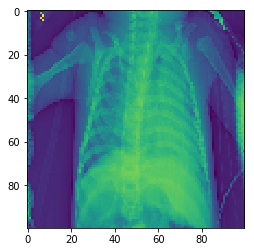

In [38]:
for pred, truth, img in zip(predictions, y_test[:5], X_test[:5]):
  
  # predict pneumonia when the pneumonia class is over 0.5    
  if pred[1] > 0.5:
    print('predicted: pneumonia')
  else:
    print('predicted: normal')
  
  # show the true value of the image   
  if truth[1]:
    print('truth: pneumonia')
  else:
    print('truth: normal')
  
  # show the image  
  plt.imshow(np.reshape(img, IMAGE_RESIZE_SHAPE))
  plt.show()  

# Done 🏁

Congratulations on building a deep neural network that does image classifciation on x-rays!  

Now that you have built this model you may want to deploy it to the Cloud so that it can be used by apps, systems, customers etc.

There is a tutorial [here](https://codelabs.developers.google.com/codelabs/what-if-tool-caip/) that covers the process of deploying a Keras model to the Cloud that you can do if you are interested. 

If you'd like to learn more about deep learning (i.e what all the layers in a neural network do) then I highly recommend [this book](https://books.google.co.uk/books?id=Yo3CAQAACAAJ&dq=Deep+Learning+With+Python&hl=en&sa=X&ved=0ahUKEwjk94ado8LkAhWFSxUIHQxwDpkQ6AEIKjAA) by François Chollet (the creator of Keras).

### *Example data imports numbers

(when using second neural network type)

likely to be a decent model
```python
NUMBER_OF_NORMAL_IMAGES_TO_IMPORT = 500 # up to 1500 
NUMBER_OF_PNEUMONIA_IMAGES_TO_IMPORT = 500 # up to 4000
IMAGE_RESIZE_SHAPE = (100, 100)
```

likely to over-fit model
```python
NUMBER_OF_NORMAL_IMAGES_TO_IMPORT = 10 # up to 1500 
NUMBER_OF_PNEUMONIA_IMAGES_TO_IMPORT = 10 # up to 4000
IMAGE_RESIZE_SHAPE = (400, 400)
```